In [81]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.utils.validation import check_symmetric
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, SpectralClustering, spectral_clustering, k_means
from sklearn.manifold import spectral_embedding

from graspologic.plot import adjplot
from graspologic.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed   
from graspologic.utils import remap_labels, is_symmetric

In [82]:
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

In [83]:
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    #(no_structure, {}),
]

<Figure size 2100x1300 with 0 Axes>

In [84]:
#get k-nearest-neighbors graphs
#dataset_names = ["noisy_circles", "noisy_moons", "varied", "aniso", "blobs", "no_structure"]
dataset_names = ["noisy_circles", "noisy_moons", "varied", "aniso", "blobs"]
nearest_neighbors_graphs = {}
nearest_neighbors_graphs_symm = {}

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )

    connectivity_symm = 0.5 * (connectivity + connectivity.T)
    
    #update the nearest neighbors dictionary
    nearest_neighbors_graphs[dataset_names[i_dataset]] = connectivity.toarray()
    nearest_neighbors_graphs_symm[dataset_names[i_dataset]] = connectivity_symm.toarray()
    print(params["n_neighbors"])
    


3
3
2
2
3


In [85]:
nearest_neighbors_symm_count = {}
nearest_neighbors_total_count = {}
for i_dataset, (dataset, mat) in enumerate(nearest_neighbors_graphs.items()):
    symm_count = 0
    total_count = 0
    for i in range(len(mat)):
        for j in range(len(mat[0])):
            #count the total number of 1s in the nearest neighbors matrix
            if mat[i][j] != 0:
                total_count += 1

            #count the total number of spots in the matrix where there is a 1 in both the current spot and its opposite (transposed) spot
            if mat[i][j] != 0 and mat[j][i] != 0:
                symm_count += 1

    nearest_neighbors_symm_count[dataset_names[i_dataset]] = symm_count
    nearest_neighbors_total_count[dataset_names[i_dataset]] = total_count
print(nearest_neighbors_symm_count)
print(nearest_neighbors_total_count)
                

{'noisy_circles': 1074, 'noisy_moons': 1082, 'varied': 670, 'aniso': 672, 'blobs': 1064}
{'noisy_circles': 1500, 'noisy_moons': 1500, 'varied': 1000, 'aniso': 1000, 'blobs': 1500}


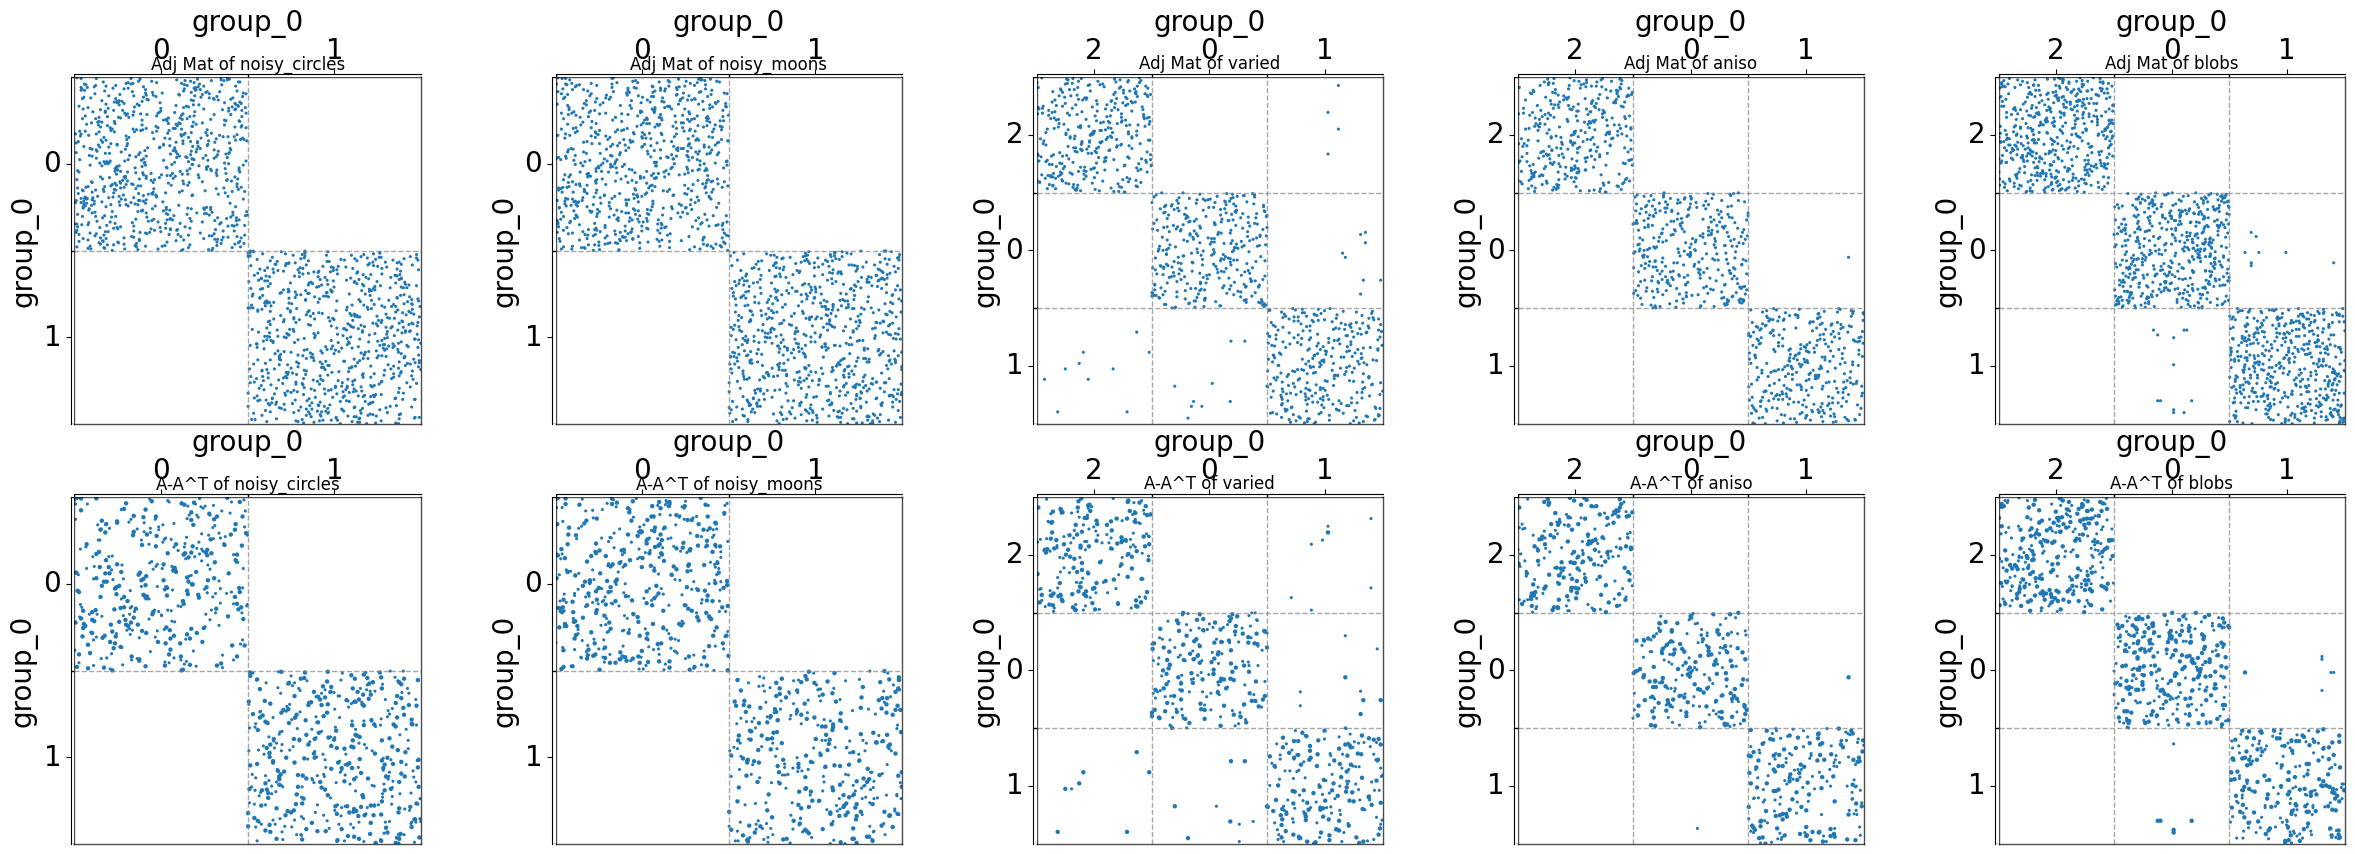

In [86]:
#plot adjacency matrices of knn graphs
fig, axs = plt.subplots(2, len(nearest_neighbors_graphs), figsize=(30, 10))
labels_list = []
for i_dataset, (dataset, mat) in enumerate(nearest_neighbors_graphs.items()):
    X, y = datasets[i_dataset][0]
    labels_list.append(y)
    A = mat.copy()
    adjplot(A, ax=axs[0, i_dataset], plot_type="scattermap", group=y)
    A_diff = A - A.T
    adjplot(A_diff, ax=axs[1, i_dataset], plot_type="scattermap", group=y)

#just title everything
for i, ax in enumerate(axs[0]):
    ax.set_title(f"Adj Mat of {list(nearest_neighbors_graphs.keys())[i]}")

for i, ax in enumerate(axs[1]):
    ax.set_title(f"A-A^T of {list(nearest_neighbors_graphs.keys())[i]}")

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byus

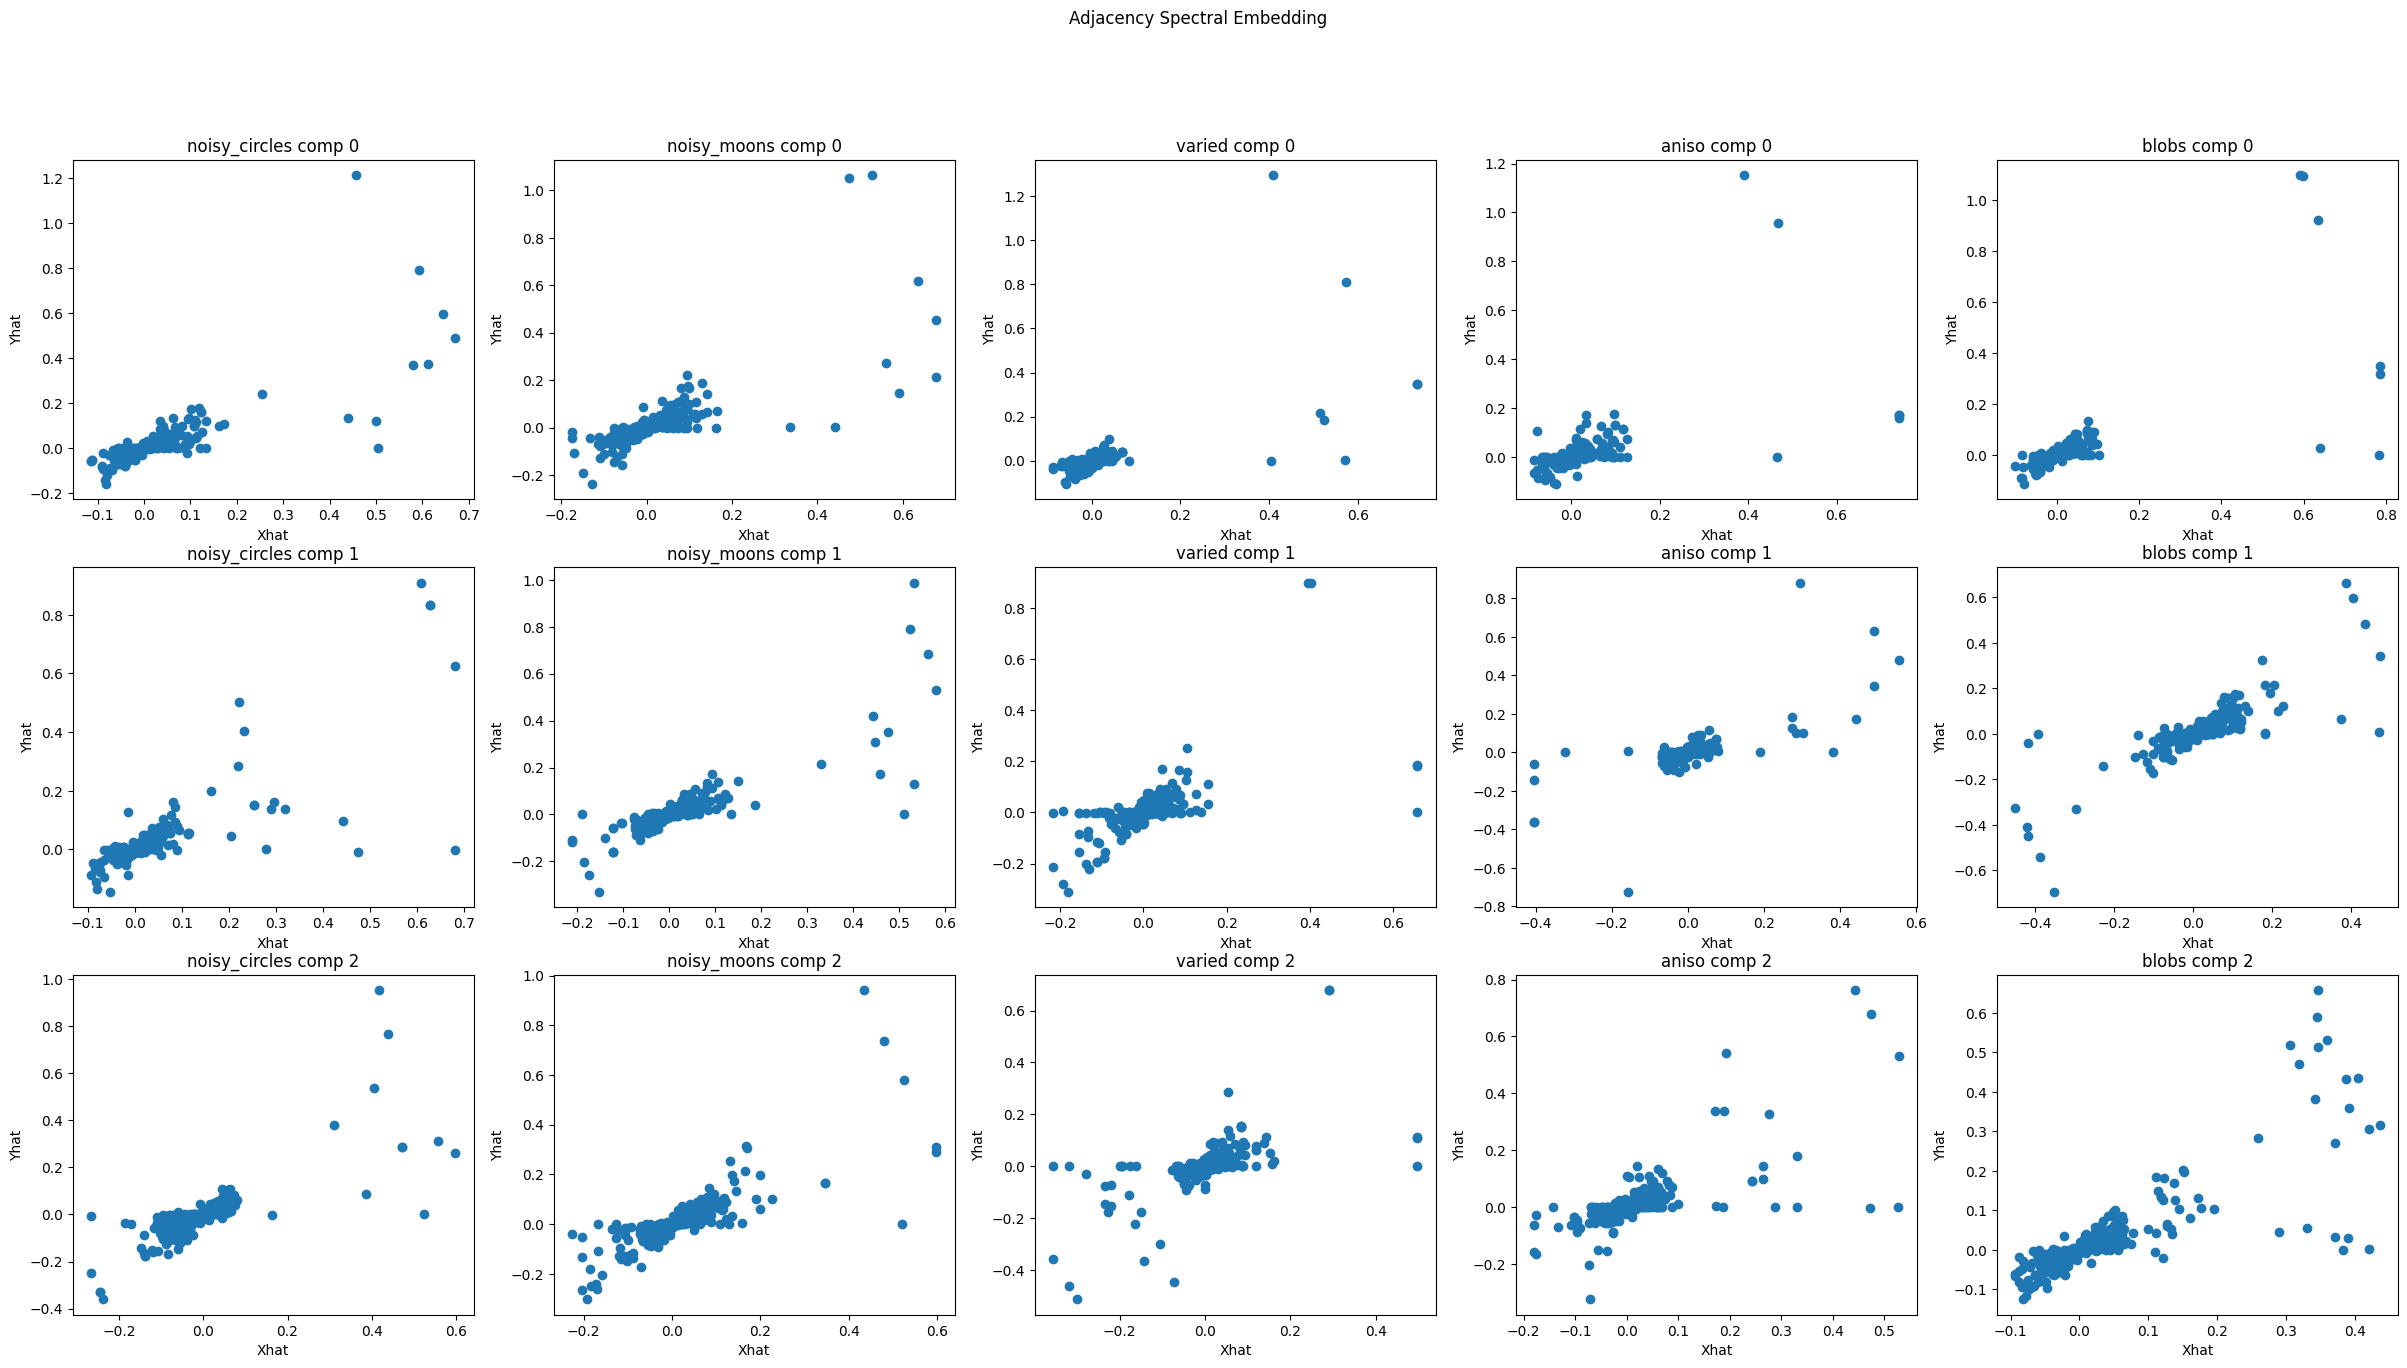

In [87]:
#do ase and clustering on the k nearest neighbor graphs (asymmetric)
n_comps = 3
fig, axs = plt.subplots(n_comps, len(nearest_neighbors_graphs), figsize=(30, 15))
fig.suptitle("Adjacency Spectral Embedding")

for i_dataset, (dataset, mat) in enumerate(nearest_neighbors_graphs.items()):
    ase = AdjacencySpectralEmbed(n_comps)
    Xhat, Yhat = ase.fit_transform(mat)

    for j in range(n_comps):
        axs[j, i_dataset].scatter(Xhat[:, j], Yhat[:, j])
        axs[j, i_dataset].set_title(f"{dataset} comp {j}")
        axs[j, i_dataset].set_xlabel("Xhat")
        axs[j, i_dataset].set_ylabel("Yhat")

In [88]:
ari_list_ase_asymm = {}
for i_dataset, (dataset, mat) in enumerate(nearest_neighbors_graphs.items()):
    ase = AdjacencySpectralEmbed()
    Xhat, Yhat = ase.fit_transform(mat)

    Xhat_combined = np.concatenate((Xhat, Yhat), axis=1)
    kmeans_ = KMeans()

    c_hat_kmeans = kmeans_.fit_predict(Xhat_combined)
    c_hat_kmeans = remap_labels(labels_list[i_dataset], c_hat_kmeans)
    ari_list_ase_asymm[dataset] = adjusted_rand_score(labels_list[i_dataset], c_hat_kmeans)


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byus

In [89]:
ari_list_ase_asymm 

{'noisy_circles': 0.005296566651432444,
 'noisy_moons': 0.1095398076468531,
 'varied': 0.002661963749623087,
 'aniso': 0.0051513155286327635,
 'blobs': 0.02413186294409786}

In [90]:
ari_list_ase_symm = {}
for i_dataset, (dataset, mat) in enumerate(nearest_neighbors_graphs_symm.items()):
    ase = AdjacencySpectralEmbed()
    Xhat = ase.fit_transform(mat)

    #Xhat_combined = np.concatenate((Xhat, Yhat), axis=1)
    kmeans_ = KMeans()

    c_hat_kmeans = kmeans_.fit_predict(Xhat)
    c_hat_kmeans = remap_labels(labels_list[i_dataset], c_hat_kmeans)
    ari_list_ase_symm[dataset] = adjusted_rand_score(labels_list[i_dataset], c_hat_kmeans)

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byus

In [91]:
ari_list_ase_symm

{'noisy_circles': 0.07177894779292478,
 'noisy_moons': 0.00698002395399789,
 'varied': 0.00262487386276879,
 'aniso': 0.011245292161091469,
 'blobs': 0.00966935271418317}

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byus

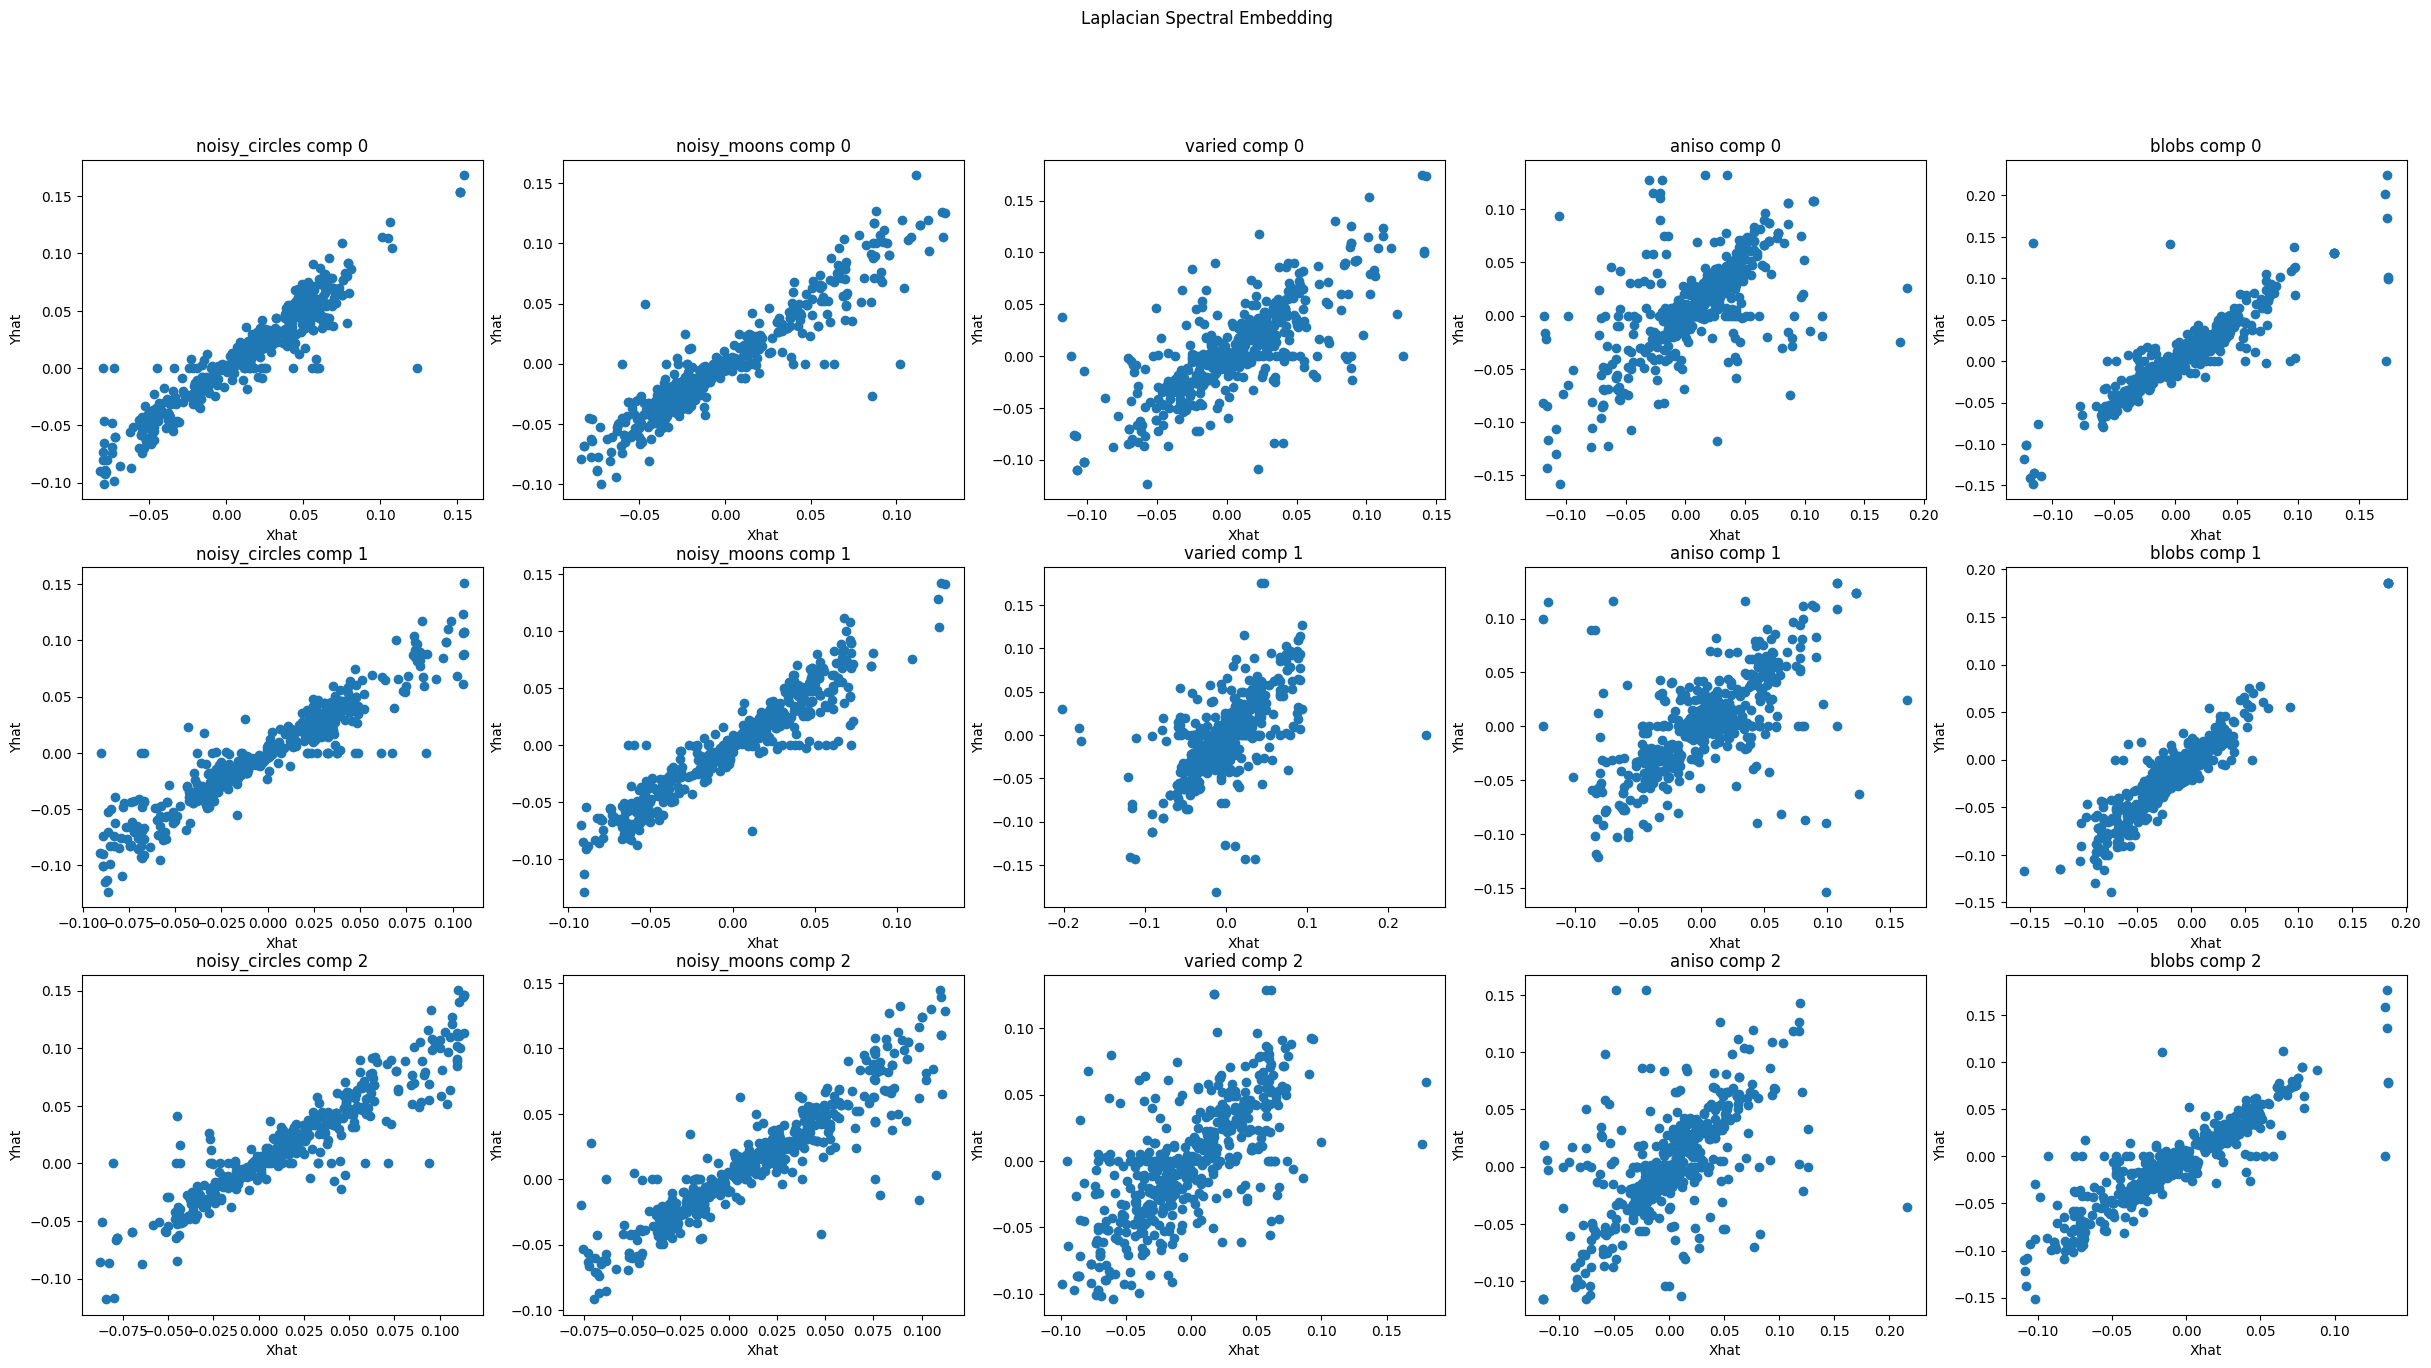

In [92]:
#do lse and clustering on the k nearest neighbor graphs (asymmetric)
n_comps = 3
fig, axs = plt.subplots(n_comps, len(nearest_neighbors_graphs), figsize=(30, 15))
fig.suptitle("Laplacian Spectral Embedding")

for i_dataset, (dataset, mat) in enumerate(nearest_neighbors_graphs.items()):
    lse = LaplacianSpectralEmbed()
    Xhat, Yhat = lse.fit_transform(mat)

    for j in range(n_comps):
        axs[j, i_dataset].scatter(Xhat[:, j], Yhat[:, j])
        axs[j, i_dataset].set_title(f"{dataset} comp {j}")
        axs[j, i_dataset].set_xlabel("Xhat")
        axs[j, i_dataset].set_ylabel("Yhat")


In [93]:
ari_list_lse_asymm = {}
for i_dataset, (dataset, mat) in enumerate(nearest_neighbors_graphs.items()):
    lse = LaplacianSpectralEmbed()
    Xhat, Yhat = lse.fit_transform(mat)

    Xhat_combined = np.concatenate((Xhat, Yhat), axis=1)
    kmeans_ = KMeans()

    c_hat_kmeans = kmeans_.fit_predict(Xhat_combined)
    #print(i_dataset)
    c_hat_kmeans = remap_labels(labels_list[i_dataset], c_hat_kmeans)
    ari_list_lse_asymm[dataset] = adjusted_rand_score(labels_list[i_dataset], c_hat_kmeans)

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byus

In [94]:
ari_list_lse_asymm

{'noisy_circles': 0.04961622438356237,
 'noisy_moons': 0.044467108138962555,
 'varied': 0.026018805447567257,
 'aniso': 0.0404772632148897,
 'blobs': 0.16754229233465395}

In [95]:
ari_list_lse_symm = {}
for i_dataset, (dataset, mat) in enumerate(nearest_neighbors_graphs_symm.items()):
    lse = LaplacianSpectralEmbed()
    Xhat = lse.fit_transform(mat)

    #Xhat_combined = np.concatenate((Xhat, Yhat), axis=1)
    kmeans_ = KMeans()

    c_hat_kmeans = kmeans_.fit_predict(Xhat)
    c_hat_kmeans = remap_labels(labels_list[i_dataset], c_hat_kmeans)
    ari_list_lse_symm[dataset] = adjusted_rand_score(labels_list[i_dataset], c_hat_kmeans)

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byus

In [96]:
ari_list_lse_symm

{'noisy_circles': 0.030588800054568276,
 'noisy_moons': 0.08825400026258813,
 'varied': 0.039736208230179065,
 'aniso': 0.09886151502647536,
 'blobs': 0.34291580941755445}

In [97]:
#using sklearn spectral clustering
from sklearn.cluster import SpectralClustering
n_iters = 100
sk_ari_dict = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}
sk_ari_list = {}
for i_dataset, (dataset, algo_params) in enumerate(datasets):   
    ari_list = []
    for _ in range(n_iters):
        # update parameters with dataset-specific values
        params = default_base.copy()
        params.update(algo_params)

        X, y = dataset
        # normalize dataset for easier parameter selection
        #X = StandardScaler().fit_transform(X)

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=params["n_neighbors"], include_self=True
        )
        sc = SpectralClustering(n_clusters=np.max(y)+1, affinity="nearest_neighbors")
        c = sc.fit(X).labels_
        c = remap_labels(labels_list[i_dataset], c)
        sk_ari_list[dataset_names[i_dataset]] = adjusted_rand_score(labels_list[i_dataset], c)
        ari_list.append(adjusted_rand_score(labels_list[i_dataset], c))
    sk_ari_dict[dataset_names[i_dataset]] = ari_list


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, sp

In [99]:
sk_ari_dict

{'noisy_circles': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'noisy_moons': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
 

In [100]:
#try implementing sklearn spectral embedding to get some insight
sk_ari_list_2 = {}
n_iters = 100
sk_ari_dict_2 = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    ari_list = []
    for _ in range(n_iters):
        # update parameters with dataset-specific values
        params = default_base.copy()
        params.update(algo_params)

        X, y = dataset
        # normalize dataset for easier parameter selection
        #X = StandardScaler().fit_transform(X)

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=10, include_self=True
        )
        connectivity = 0.5 * (connectivity + connectivity.T)

        maps = spectral_embedding(connectivity, n_components=np.max(y)+1, drop_first=False)
        #ase = AdjacencySpectralEmbed()
        #maps = ase.fit_transform(connectivity.toarray())
        #kmeans_ = KMeans()
        #c = kmeans_.fit_predict(maps)
        _, c, _ = k_means(maps, n_clusters=np.max(y)+1)
        #sc = SpectralClustering(n_clusters=np.max(y)+1, affinity="nearest_neighbors")
        #c = sc.fit(connectivity).labels_
        c = remap_labels(labels_list[i_dataset], c)
        sk_ari_list_2[dataset_names[i_dataset]] = adjusted_rand_score(labels_list[i_dataset], c)
        ari_list.append(adjusted_rand_score(labels_list[i_dataset], c))
    sk_ari_dict_2[dataset_names[i_dataset]] = ari_list
    

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, sp

In [102]:
sk_ari_dict_2

{'noisy_circles': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'noisy_moons': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
 

In [103]:
#try implementing sklearn spectral embedding to get some insight
n_iters = 100
sk_asymm_ari_dict_2 = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    ari_list = []
    for _ in range(n_iters):
        # update parameters with dataset-specific values
        params = default_base.copy()
        params.update(algo_params)

        X, y = dataset
        # normalize dataset for easier parameter selection
        #X = StandardScaler().fit_transform(X)

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=10, include_self=True
        )
        #connectivity = 0.5 * (connectivity + connectivity.T)

        maps = spectral_embedding(connectivity, n_components=np.max(y)+1, drop_first=False)
        #ase = AdjacencySpectralEmbed()
        #maps = ase.fit_transform(connectivity.toarray())
        #kmeans_ = KMeans()
        #c = kmeans_.fit_predict(maps)
        _, c, _ = k_means(maps, n_clusters=np.max(y)+1)
        #sc = SpectralClustering(n_clusters=np.max(y)+1, affinity="nearest_neighbors")
        #c = sc.fit(connectivity).labels_
        c = remap_labels(labels_list[i_dataset], c)
        ari_list.append(adjusted_rand_score(labels_list[i_dataset], c))
    sk_asymm_ari_dict_2[dataset_names[i_dataset]] = ari_list
    

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:275: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/sklearn/mani

In [104]:
sk_asymm_ari_dict_2

{'noisy_circles': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'noisy_moons': [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
 

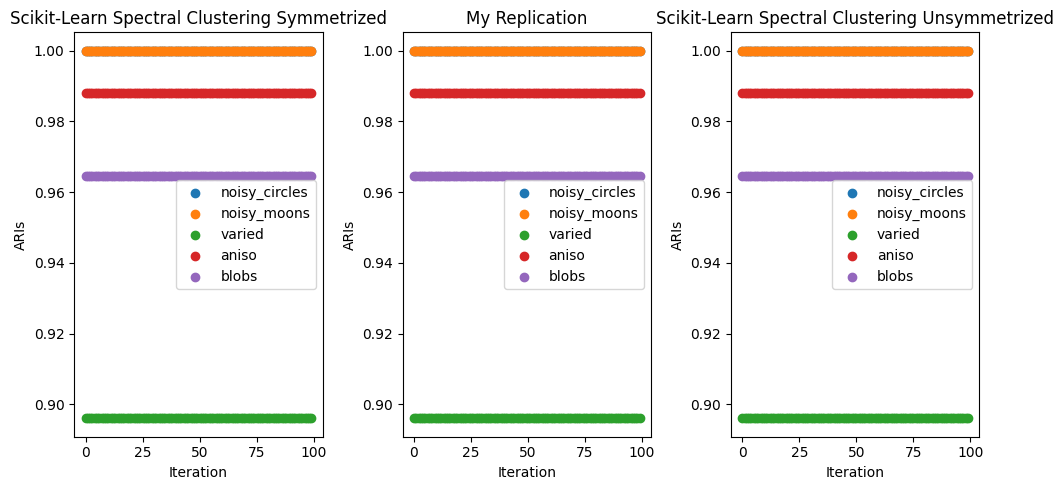

In [122]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for key, value in sk_ari_dict.items():
    axs[0].scatter(np.arange(100), value, label=key)

for key, value in sk_ari_dict_2.items():
    axs[1].scatter(np.arange(100), value, label=key)

for key, value in sk_asymm_ari_dict_2.items():
    axs[2].scatter(np.arange(100), value, label=key)

axs[0].legend()
axs[1].legend()
axs[2].legend()

axs[0].set_title("Scikit-Learn Spectral Clustering Symmetrized")
axs[1].set_title("My Replication")
axs[2].set_title("Scikit-Learn Spectral Clustering Unsymmetrized")

axs[0].set_xlabel("Iteration")
axs[1].set_xlabel("Iteration")
axs[2].set_xlabel("Iteration")

axs[0].set_ylabel("ARIs")
axs[1].set_ylabel("ARIs")
axs[2].set_ylabel("ARIs")

plt.tight_layout()
plt.show()

In [106]:
#run 100 times, plot aris for their implementation and my replication
#start with keeping symmetry, make sure ASE/LSE give similar results to spectral_embedding, run many times

In [107]:
#ASE symmetrized
n_iters = 100
ase_symm_ari_dict_rand = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}
ase_symm_ari_dict_full = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}
ase_symm_ari_dict_trunc = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    ari_list_rand = []
    ari_list_full = []
    ari_list_trunc = []

    for _ in range(n_iters):
        # update parameters with dataset-specific values
        params = default_base.copy()
        params.update(algo_params)

        X, y = dataset
        # normalize dataset for easier parameter selection
        #X = StandardScaler().fit_transform(X)

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=10, include_self=True
        )
        connectivity = 0.5 * (connectivity + connectivity.T)

        ase_rand = AdjacencySpectralEmbed(n_components=np.max(y)+1)
        ase_full = AdjacencySpectralEmbed(n_components=np.max(y)+1, algorithm="full")
        ase_trunc = AdjacencySpectralEmbed(n_components=np.max(y)+1, algorithm="truncated")

        maps_rand = ase_rand.fit_transform(connectivity.toarray())
        maps_full = ase_full.fit_transform(connectivity.toarray())
        maps_trunc = ase_trunc.fit_transform(connectivity.toarray())

        _, c_rand, _ = k_means(maps_rand, n_clusters=np.max(y)+1)
        _, c_full, _ = k_means(maps_full, n_clusters=np.max(y)+1)
        _, c_trunc, _ = k_means(maps_trunc, n_clusters=np.max(y)+1)

        c_rand = remap_labels(labels_list[i_dataset], c_rand)
        c_full = remap_labels(labels_list[i_dataset], c_full)
        c_trunc = remap_labels(labels_list[i_dataset], c_trunc)

        ari_list_rand.append(adjusted_rand_score(labels_list[i_dataset], c_rand))
        ari_list_full.append(adjusted_rand_score(labels_list[i_dataset], c_full))
        ari_list_trunc.append(adjusted_rand_score(labels_list[i_dataset], c_trunc))

    ase_symm_ari_dict_rand[dataset_names[i_dataset]] = ari_list_rand
    ase_symm_ari_dict_full[dataset_names[i_dataset]] = ari_list_full
    ase_symm_ari_dict_trunc[dataset_names[i_dataset]] = ari_list_trunc

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byus

100
100
100
100
100
100
100
100
100
100
100
100
100
100
100


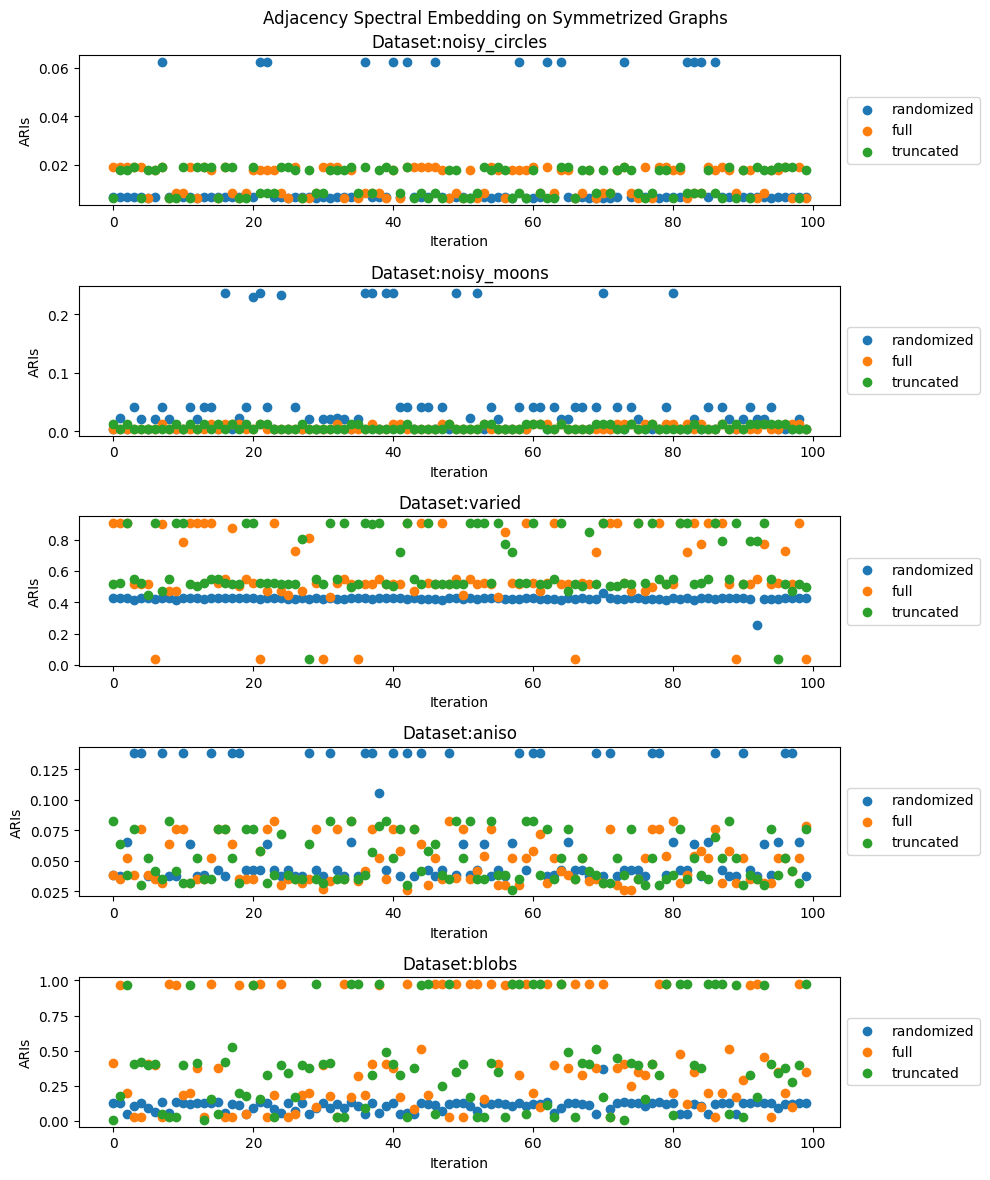

In [109]:
#change orientation of dictionaries
ase_symm_dict_list = []
for key in ase_symm_ari_dict_rand.keys():
    ase_symm_dict_list.append({'randomized': ase_symm_ari_dict_rand[key], 'full': ase_symm_ari_dict_full[key], 'truncated': ase_symm_ari_dict_trunc[key]})

fig, axs = plt.subplots(5, 1, figsize=(10, 12))
for i in range(len(ase_symm_dict_list)):
    for (key, value) in ase_symm_dict_list[i].items():
        print(len(value))
        axs[i].scatter(np.arange(100), value, label=key)
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[i].set_title(f"Dataset:{dataset_names[i]}")
        axs[i].set_xlabel("Iteration")
        axs[i].set_ylabel("ARIs")

fig.suptitle("Adjacency Spectral Embedding on Symmetrized Graphs")

plt.tight_layout()
plt.show()

In [113]:
print(ase_symm_dict_list[2]["truncated"])

[0.5175822045868964, 0.5244676688919878, 0.9072545900133013, 0.5458699878123622, 0.5244676688919878, 0.44425304989615, 0.9072545900133013, 0.47063582593650033, 0.5458699878123622, 0.9072545900133013, 0.9072545900133013, 0.5175822045868964, 0.504625441667553, 0.5244676688919878, 0.5458699878123622, 0.5458699878123622, 0.5244676688919878, 0.5175822045868964, 0.5175822045868964, 0.9072545900133013, 0.9072545900133013, 0.5244676688919878, 0.5244676688919878, 0.5244676688919878, 0.5175822045868964, 0.5175822045868964, 0.5175822045868964, 0.8038709032466654, 0.03906881278865069, 0.5458699878123622, 0.5175822045868964, 0.9072545900133013, 0.5458699878123622, 0.9072545900133013, 0.4977294795909538, 0.5175822045868964, 0.9072545900133013, 0.9017477068809957, 0.9072545900133013, 0.5175822045868964, 0.504625441667553, 0.7208709961035551, 0.9072545900133013, 0.5458699878123622, 0.5175822045868964, 0.9072545900133013, 0.5175822045868964, 0.5175822045868964, 0.5175822045868964, 0.5175822045868964, 0

In [115]:
#LSE symmetrized
n_iters = 100
lse_symm_ari_dict_rand = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}
lse_symm_ari_dict_full = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}
lse_symm_ari_dict_trunc = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    ari_list_rand = []
    ari_list_full = []
    ari_list_trunc = []

    for _ in range(n_iters):
        # update parameters with dataset-specific values
        params = default_base.copy()
        params.update(algo_params)

        X, y = dataset
        # normalize dataset for easier parameter selection
        #X = StandardScaler().fit_transform(X)

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=10, include_self=True
        )
        connectivity = 0.5 * (connectivity + connectivity.T)

        lse_rand = LaplacianSpectralEmbed(n_components=np.max(y)+1)
        lse_full = LaplacianSpectralEmbed(n_components=np.max(y)+1, algorithm="full")
        lse_trunc = LaplacianSpectralEmbed(n_components=np.max(y)+1, algorithm="truncated")

        maps_rand = lse_rand.fit_transform(connectivity.toarray())
        maps_full = lse_full.fit_transform(connectivity.toarray())
        maps_trunc = lse_trunc.fit_transform(connectivity.toarray())

        _, c_rand, _ = k_means(maps_rand, n_clusters=np.max(y)+1)
        _, c_full, _ = k_means(maps_full, n_clusters=np.max(y)+1)
        _, c_trunc, _ = k_means(maps_trunc, n_clusters=np.max(y)+1)

        c_rand = remap_labels(labels_list[i_dataset], c_rand)
        c_full = remap_labels(labels_list[i_dataset], c_full)
        c_trunc = remap_labels(labels_list[i_dataset], c_trunc)

        ari_list_rand.append(adjusted_rand_score(labels_list[i_dataset], c_rand))
        ari_list_full.append(adjusted_rand_score(labels_list[i_dataset], c_full))
        ari_list_trunc.append(adjusted_rand_score(labels_list[i_dataset], c_trunc))

    lse_symm_ari_dict_rand[dataset_names[i_dataset]] = ari_list_rand
    lse_symm_ari_dict_full[dataset_names[i_dataset]] = ari_list_full
    lse_symm_ari_dict_trunc[dataset_names[i_dataset]] = ari_list_trunc

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byus

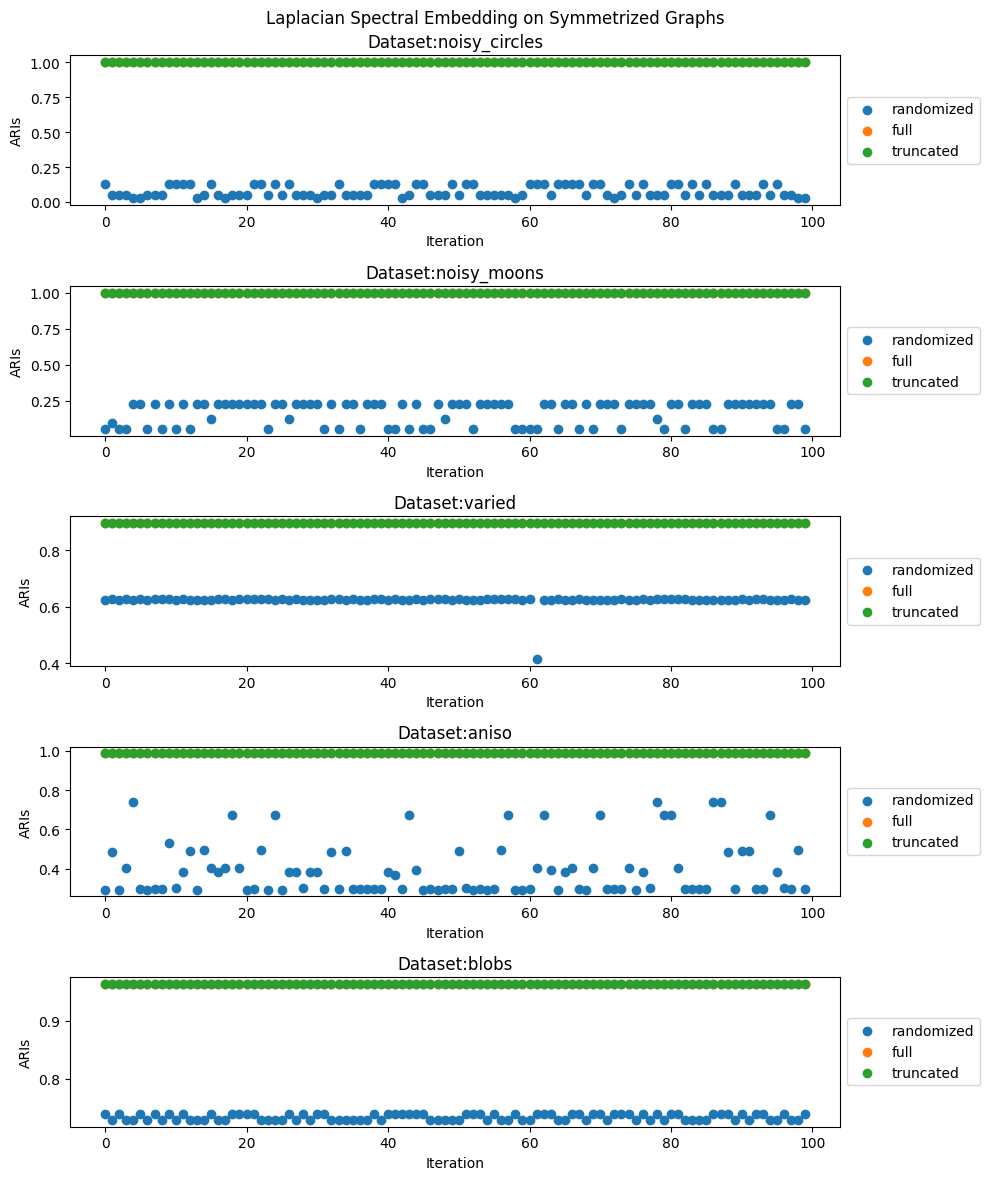

In [116]:
#change orientation of dictionaries
lse_symm_dict_list = []
for key in lse_symm_ari_dict_rand.keys():
    lse_symm_dict_list.append({'randomized': lse_symm_ari_dict_rand[key], 'full': lse_symm_ari_dict_full[key], 'truncated': lse_symm_ari_dict_trunc[key]})

fig, axs = plt.subplots(5, 1, figsize=(10, 12))
for i in range(len(lse_symm_dict_list)):
    for (key, value) in lse_symm_dict_list[i].items():
        axs[i].scatter(np.arange(100), value, label=key)
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[i].set_title(f"Dataset:{dataset_names[i]}")
        axs[i].set_xlabel("Iteration")
        axs[i].set_ylabel("ARIs")

fig.suptitle("Laplacian Spectral Embedding on Symmetrized Graphs")

plt.tight_layout()
plt.show()

In [117]:
#ASE unsymmetrized
n_iters = 100
ase_asymm_ari_dict_rand = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}
ase_asymm_ari_dict_full = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}
ase_asymm_ari_dict_trunc = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    ari_list_rand = []
    ari_list_full = []
    ari_list_trunc = []

    for _ in range(n_iters):
        # update parameters with dataset-specific values
        params = default_base.copy()
        params.update(algo_params)

        X, y = dataset
        # normalize dataset for easier parameter selection
        #X = StandardScaler().fit_transform(X)

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=10, include_self=True
        )
        #connectivity = 0.5 * (connectivity + connectivity.T)

        ase_rand = AdjacencySpectralEmbed(n_components=np.max(y)+1)
        ase_full = AdjacencySpectralEmbed(n_components=np.max(y)+1, algorithm="full")
        ase_trunc = AdjacencySpectralEmbed(n_components=np.max(y)+1, algorithm="truncated")

        Xhat_rand, Yhat_rand = ase_rand.fit_transform(connectivity.toarray())
        Xhat_full, Yhat_full = ase_full.fit_transform(connectivity.toarray())
        Xhat_trunc, Yhat_trunc = ase_trunc.fit_transform(connectivity.toarray())

        Xhat_rand_combined = np.concatenate((Xhat_rand, Yhat_rand), axis=1)
        Xhat_full_combined = np.concatenate((Xhat_full, Yhat_full), axis=1)
        Xhat_trunc_combined = np.concatenate((Xhat_trunc, Yhat_trunc), axis=1)

        _, c_rand, _ = k_means(Xhat_rand_combined, n_clusters=np.max(y)+1)
        _, c_full, _ = k_means(Xhat_full_combined, n_clusters=np.max(y)+1)
        _, c_trunc, _ = k_means(Xhat_trunc_combined, n_clusters=np.max(y)+1)

        c_rand = remap_labels(labels_list[i_dataset], c_rand)
        c_full = remap_labels(labels_list[i_dataset], c_full)
        c_trunc = remap_labels(labels_list[i_dataset], c_trunc)

        ari_list_rand.append(adjusted_rand_score(labels_list[i_dataset], c_rand))
        ari_list_full.append(adjusted_rand_score(labels_list[i_dataset], c_full))
        ari_list_trunc.append(adjusted_rand_score(labels_list[i_dataset], c_trunc))

    ase_asymm_ari_dict_rand[dataset_names[i_dataset]] = ari_list_rand
    ase_asymm_ari_dict_full[dataset_names[i_dataset]] = ari_list_full
    ase_asymm_ari_dict_trunc[dataset_names[i_dataset]] = ari_list_trunc

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byus

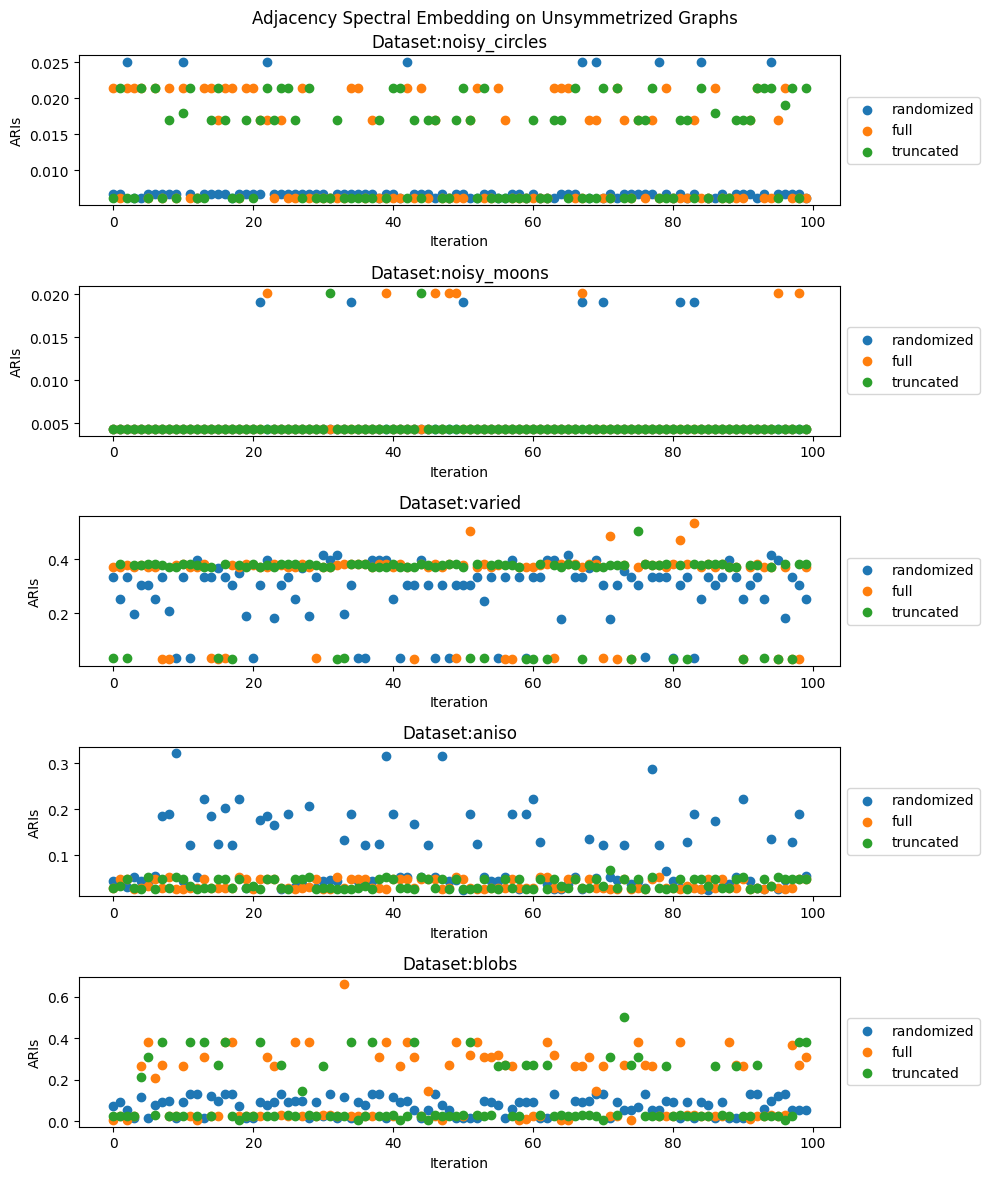

In [118]:
#change orientation of dictionaries
ase_asymm_dict_list = []
for key in ase_asymm_ari_dict_rand.keys():
    ase_asymm_dict_list.append({'randomized': ase_asymm_ari_dict_rand[key], 'full': ase_asymm_ari_dict_full[key], 'truncated': ase_asymm_ari_dict_trunc[key]})

fig, axs = plt.subplots(5, 1, figsize=(10, 12))
for i in range(len(ase_asymm_dict_list)):
    for (key, value) in ase_asymm_dict_list[i].items():
        axs[i].scatter(np.arange(100), value, label=key)
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[i].set_title(f"Dataset:{dataset_names[i]}")
        axs[i].set_xlabel("Iteration")
        axs[i].set_ylabel("ARIs")

fig.suptitle("Adjacency Spectral Embedding on Unsymmetrized Graphs")

plt.tight_layout()
plt.show()

In [119]:
#LSE unsymmetrized
n_iters = 100
lse_asymm_ari_dict_rand = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}
lse_asymm_ari_dict_full = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}
lse_asymm_ari_dict_trunc = {"noisy_circles": None, "noisy_moons": None, "varied": None, "aniso": None, "blobs": None}

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    ari_list_rand = []
    ari_list_full = []
    ari_list_trunc = []

    for _ in range(n_iters):
        # update parameters with dataset-specific values
        params = default_base.copy()
        params.update(algo_params)

        X, y = dataset
        # normalize dataset for easier parameter selection
        #X = StandardScaler().fit_transform(X)

        # connectivity matrix for structured Ward
        connectivity = kneighbors_graph(
            X, n_neighbors=10, include_self=True
        )
        #connectivity = 0.5 * (connectivity + connectivity.T)

        lse_rand = LaplacianSpectralEmbed(n_components=np.max(y)+1)
        lse_full = LaplacianSpectralEmbed(n_components=np.max(y)+1, algorithm="full")
        lse_trunc = LaplacianSpectralEmbed(n_components=np.max(y)+1, algorithm="truncated")

        Xhat_rand, Yhat_rand = lse_rand.fit_transform(connectivity.toarray())
        Xhat_full, Yhat_full = lse_full.fit_transform(connectivity.toarray())
        Xhat_trunc, Yhat_trunc = lse_trunc.fit_transform(connectivity.toarray())

        Xhat_rand_combined = np.concatenate((Xhat_rand, Yhat_rand), axis=1)
        Xhat_full_combined = np.concatenate((Xhat_full, Yhat_full), axis=1)
        Xhat_trunc_combined = np.concatenate((Xhat_trunc, Yhat_trunc), axis=1)

        _, c_rand, _ = k_means(Xhat_rand_combined, n_clusters=np.max(y)+1)
        _, c_full, _ = k_means(Xhat_full_combined, n_clusters=np.max(y)+1)
        _, c_trunc, _ = k_means(Xhat_trunc_combined, n_clusters=np.max(y)+1)

        c_rand = remap_labels(labels_list[i_dataset], c_rand)
        c_full = remap_labels(labels_list[i_dataset], c_full)
        c_trunc = remap_labels(labels_list[i_dataset], c_trunc)

        ari_list_rand.append(adjusted_rand_score(labels_list[i_dataset], c_rand))
        ari_list_full.append(adjusted_rand_score(labels_list[i_dataset], c_full))
        ari_list_trunc.append(adjusted_rand_score(labels_list[i_dataset], c_trunc))

    lse_asymm_ari_dict_rand[dataset_names[i_dataset]] = ari_list_rand
    lse_asymm_ari_dict_full[dataset_names[i_dataset]] = ari_list_full
    lse_asymm_ari_dict_trunc[dataset_names[i_dataset]] = ari_list_trunc

/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byusing ``graspologic.utils.largest_connected_component``.
  warnings.warn(msg, UserWarning)
/Users/kareefullah/Desktop/NeuroData/neurodata/sklearn-proj-folder/sklearn-proj/.venv/lib/python3.11/site-packages/graspologic/embed/base.py:199: UserWarning: Input graph is not fully connected. Results may notbe optimal. You can compute the largest connected component byus

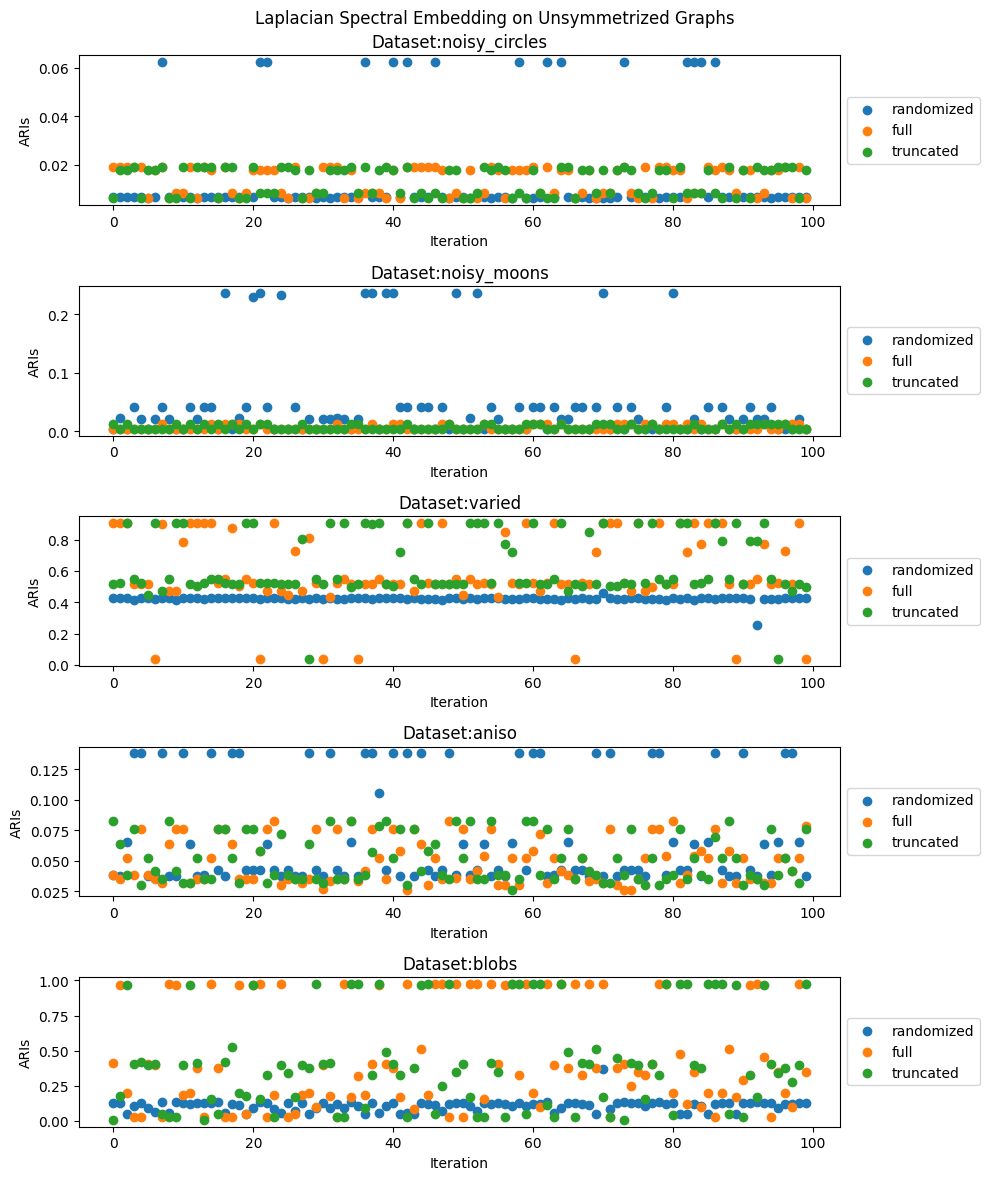

In [120]:
#change orientation of dictionaries
lse_asymm_dict_list = []
for key in lse_asymm_ari_dict_rand.keys():
    lse_asymm_dict_list.append({'randomized': lse_asymm_ari_dict_rand[key], 'full': lse_asymm_ari_dict_full[key], 'truncated': lse_asymm_ari_dict_trunc[key]})

fig, axs = plt.subplots(5, 1, figsize=(10, 12))
for i in range(len(lse_asymm_dict_list)):
    for (key, value) in ase_symm_dict_list[i].items():
        axs[i].scatter(np.arange(100), value, label=key)
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        axs[i].set_title(f"Dataset:{dataset_names[i]}")
        axs[i].set_xlabel("Iteration")
        axs[i].set_ylabel("ARIs")

fig.suptitle("Laplacian Spectral Embedding on Unsymmetrized Graphs")

plt.tight_layout()
plt.show()